In [29]:
import pandas as pd
import seaborn as sns

In [30]:
df = pd.read_csv('data/candy_production.csv')

In [31]:
df.head()

,date,IPG3113N
0,1972-01-01,85.598809
1,1972-02-01,71.741404
2,1972-03-01,65.948809
3,1972-04-01,64.490724
4,1972-05-01,64.933842


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564 entries, 0 to 563
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      564 non-null    object 
 1   IPG3113N  564 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.9+ KB


In [33]:
df['date'] = df['date'].astype('datetime64')
df.set_index('date',inplace=True)

<AxesSubplot: xlabel='date'>

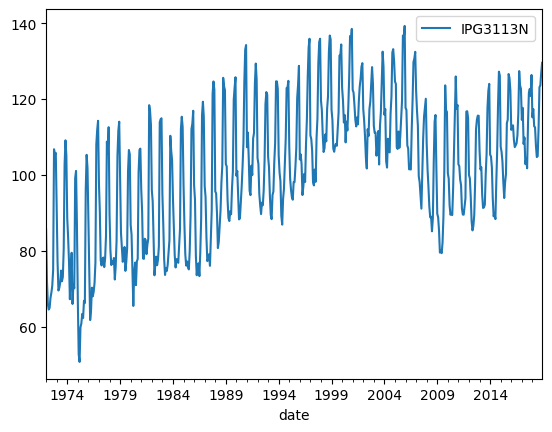

In [34]:
df.plot()

## EDA - Séries temporais

In [35]:
#!pip install --upgrade statsmodels

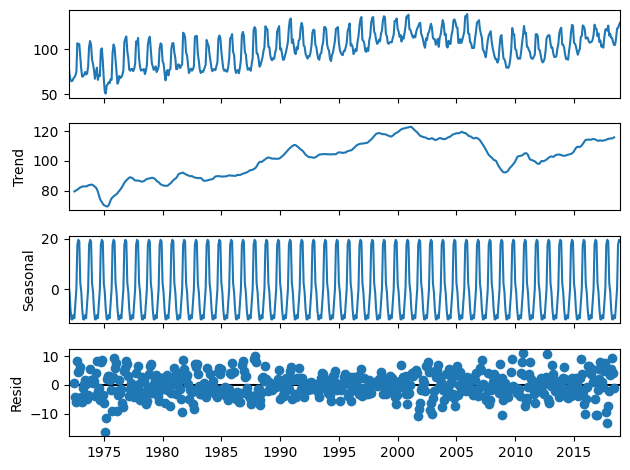

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df, model='additive') # Additive sem um incremento da série como se fosse uma progessão geométrica por exemplo
result.plot();

Existe uma tendência e a componente sazonal bem definida no que aparenta ser componente sazonal anual da venda de doces.

In [37]:
from toolbox import series_screw as ssc

In [38]:
ssc.adfuller_eval_sta(df) #Será necessário diferenciar pelo menos 1 vez 

'p_value: 0.39243275007140427 não podemos rejeitar Ho. Série Não Estacionária'

### Diferenciação

In [39]:
df_diff = df.diff().dropna()

ssc.adfuller_eval_sta(df_diff) #1 diferenciação já foi suficiente

'p_value: 6.631549159334886e-08 rejeita-se Ho. Esta séries é estacionária'

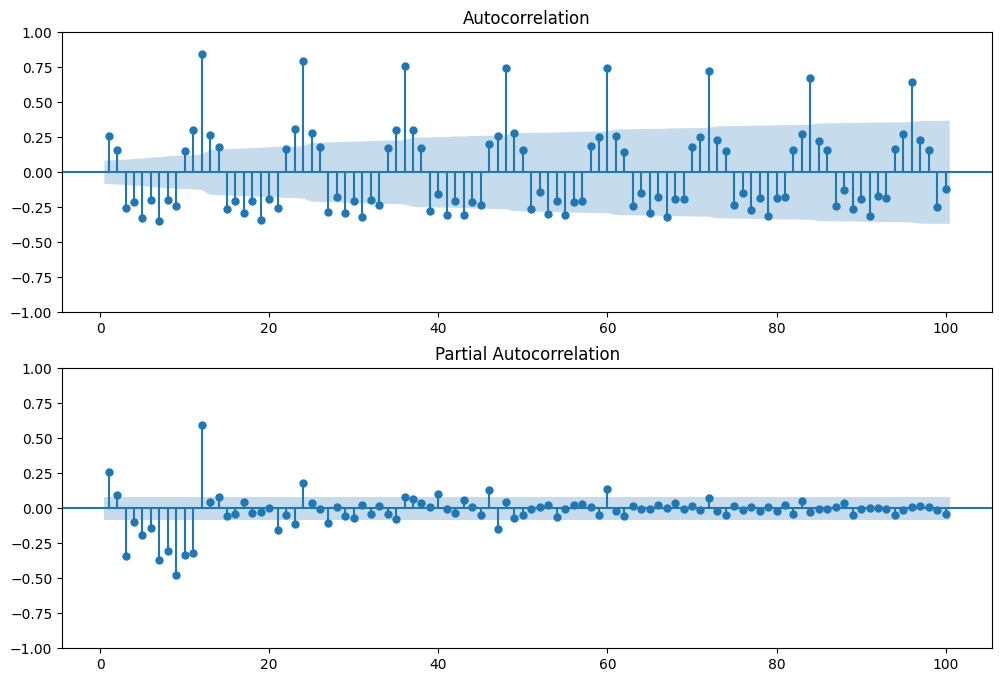

In [40]:
ssc.acf_pacf(df_diff,lags=100)

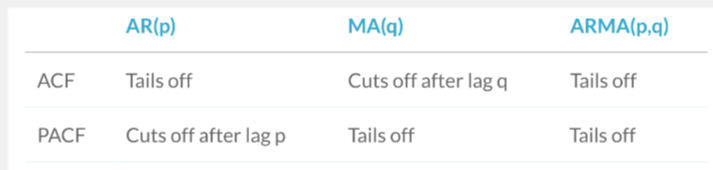

### Diferenciação Sazonal

## Modelos

Vamos imaginar um cenário onde quero prever os próximos 3 meses com base no histório (1 Quarter)

Testando diferentes formas de resolver um forecasting

- SARIMAX
- Regressors
- Redes Neurais

In [41]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

### Preparando treino

Assim como em um modelo comum, precisamos também fazer uma validação cruzada nos nossos dados, isso porque se analisarmos apenas um 
momento no tempo podemos ter tido a performance por acaso, por isso sempre é interessante validar em diferentes folds ao longo do tempo.

Série Temporal leva em conta o tempo e por isso não podemos simplesmente mistura-lo, por isso vamos utilizar time series cross validation
para que seja possível respeitar a ordem temporal.

![alternative text](images\types_time_series_split.png)

In [59]:
tscv = TimeSeriesSplit(n_splits=5,test_size=6)

for train_index, test_index in tscv.split(df):

    print(len(train_index),len(test_index))

534 6
540 6
546 6
552 6
558 6


In [60]:
import matplotlib.pyplot as plt
import warnings
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
warnings.filterwarnings('ignore')

def plot_cv_indices(cv, X, y=None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(1, 1, figsize = (11, 7))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + 1] * len(indices),
                   c=indices, lw=10, cmap=cmap_cv, marker='_',
                   vmin=-.2, vmax=1.2)
        
    ax.invert_yaxis()

    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    

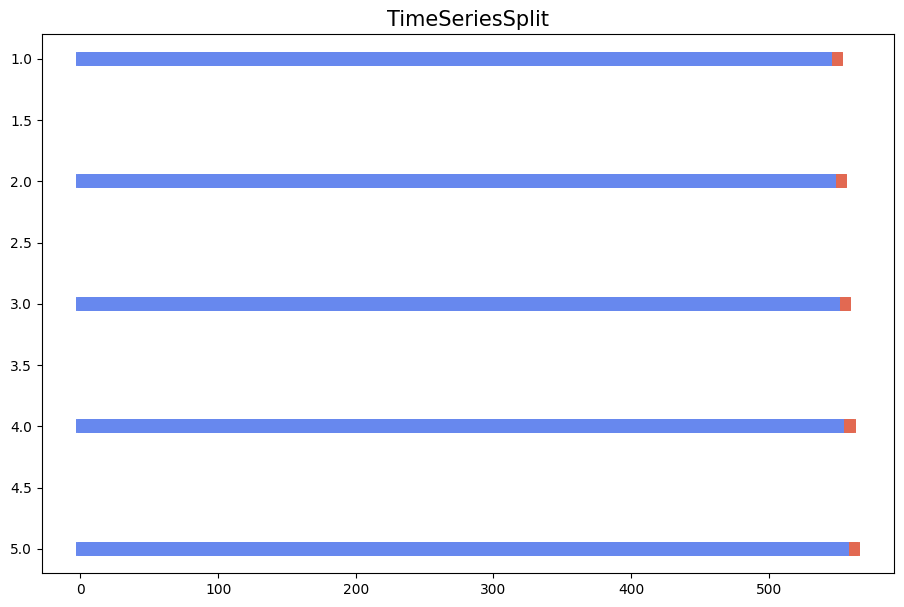

In [61]:
tscv = TimeSeriesSplit(n_splits=5,test_size=3)
plot_cv_indices(cv=tscv,X=df)

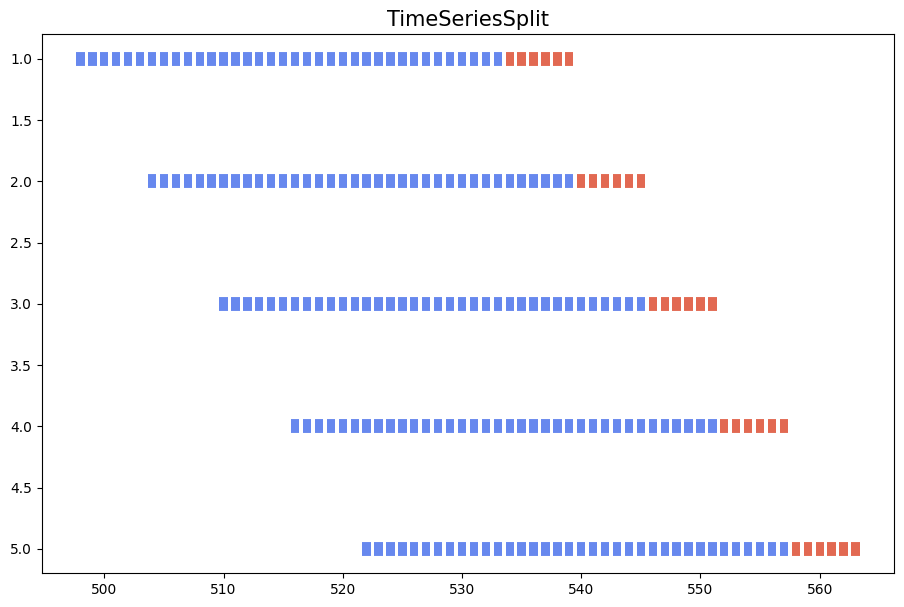

In [62]:
tscv = TimeSeriesSplit(n_splits=5,test_size=6,max_train_size=36)
plot_cv_indices(cv=tscv,X=df)

## Métricas de Erro

## Autoarima

In [46]:
#!pip install pmdarima

In [63]:
train = df.iloc[:-9]
test = df.iloc[-9:]

In [64]:
train

,IPG3113N
date,
1972-01-01,85.598809
1972-02-01,71.741404
1972-03-01,65.948809
1972-04-01,64.490724
1972-05-01,64.933842
...,...
2017-11-01,120.838739
2017-12-01,126.362886
2018-01-01,115.193151


In [49]:
import pmdarima as pm

# Vamos rodar o autoarima para encontrar melhores parâmetros (p,d,q)(P,D,Q)[m]
# Após encontrar melhores parâmetros podemos fazer uma validação cruzada.
  
model = pm.auto_arima(train, 
                      seasonal=True,
                      d=1,
                      m=12,
                      maxiter=50,
                      n_jobs=-1)

In [50]:
model

ARIMA(order=(1, 1, 2), scoring_args={}, seasonal_order=(1, 0, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [51]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  555
Model:             SARIMAX(1, 1, 2)x(1, 0, 2, 12)   Log Likelihood               -1530.491
Date:                            Mon, 30 Oct 2023   AIC                           3074.982
Time:                                    18:51:16   BIC                           3105.202
Sample:                                01-01-1972   HQIC                          3086.787
                                     - 03-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8414      0.040     20.978      0.000       0.763       0.920
ma.L1         -1.1482      0.061    -18.899      0.000      -1.267      -1.029
ma.L2          0.1752      0.052      3.354      0.001       0.073       0.278
ar.S.L12       0.9937      0.002    508.916      0.000       0.990       0.998
ma.S.L12      -0.6103      0.040    -15.441      0.000      -0.688      -0.533
ma.S.L24      -0.1285      0.038     -3.339      0.001      -0.204      -0.053
sigma2        13.9359      0.703     19.812      0.000      12.557      15.315
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                32.48
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                            -0.19
Prob(H) (two-sided):                  0.21   Kurtosis:                         4.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

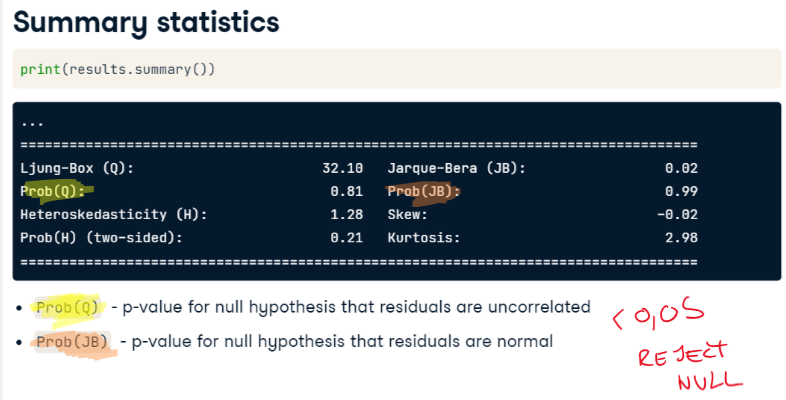

- Residuos não possuem autocorrelação, Prob(Q) >0.05 não podemos rejeitar a nula
- Prob(JB) <0.05 ou seja rejeitamos a hipótese de que é normal -> melhorar modelo.

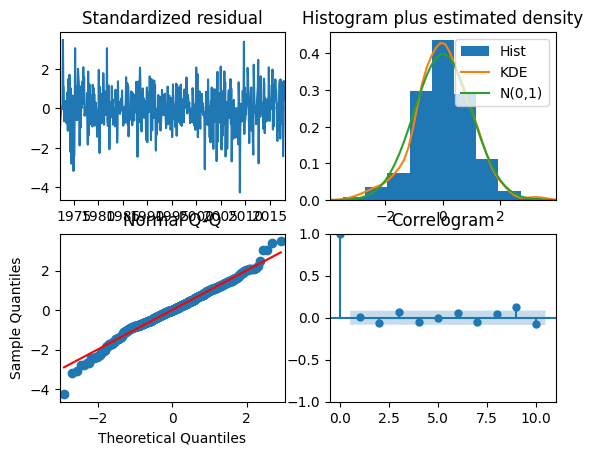

In [52]:
model.plot_diagnostics();

### Mudança entre treino e teste

Parece que não estamos bem em encontrar o padrão da série sobrou residuos não normais, será que podemos melhorar AIC e residuos filtrando melhor o treino?

In [53]:
len(train)

555

In [54]:
train = df.iloc[(-32-9):-9] # Pegando apenas tres anos anteriores
test = df.iloc[-9:]

In [55]:
# Vamos rodar o autoarima para encontrar melhores parâmetros (p,d,q)(P,D,Q)[m]
# Após encontrar melhores parâmetros podemos fazer uma validação cruzada.
  
model = pm.auto_arima(train, 
                      seasonal=True,
                      d=1,
                      m=12,
                      maxiter=50,
                      n_jobs=-1)

In [56]:
model

ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [57]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   32
Model:             SARIMAX(3, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 -53.203
Date:                            Mon, 30 Oct 2023   AIC                            114.406
Time:                                    18:51:19   BIC                            118.184
Sample:                                08-01-2015   HQIC                           115.046
                                     - 03-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7164      0.221     -3.235      0.001      -1.150      -0.282
ar.L2         -0.6554      0.227     -2.893      0.004      -1.099      -0.211
ar.L3         -0.3408      0.313     -1.087      0.277      -0.955       0.274
sigma2        15.0153      7.027      2.137      0.033       1.243      28.788
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.33
Prob(Q):                              0.96   Prob(JB):                         0.85
Heteroskedasticity (H):               0.88   Skew:                            -0.16
Prob(H) (two-sided):                  0.88   Kurtosis:                         2.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Bem melhor! Resíduos normais, sem autocorrelação nos lags e AIC >30x menor do que anterior 3074.982
Poderiamos ainda testar menor AIC para > ou < anos no treino

### Validação Cruzada 

Utilizando validação cruzada em 3 quarters, faremos isso para benchmarking posterior.

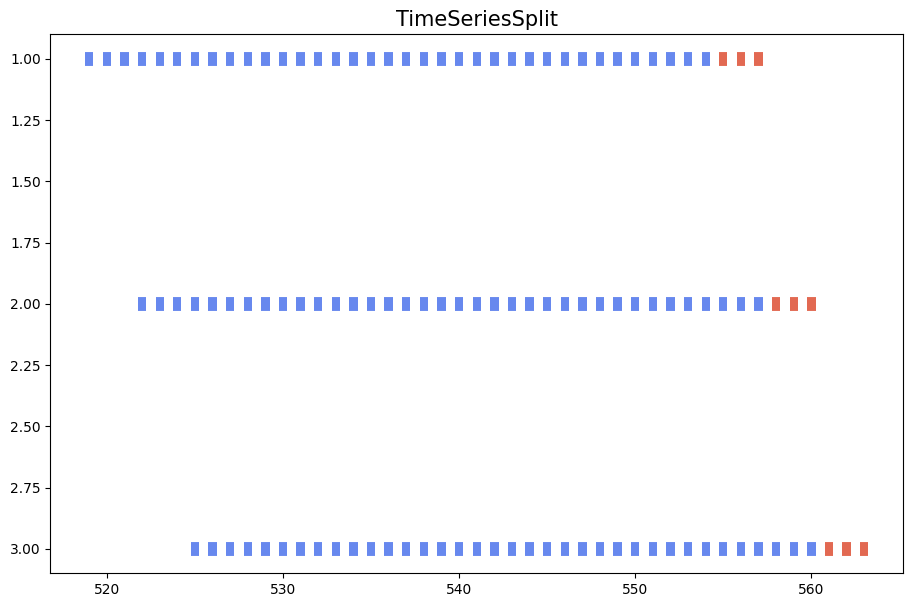

In [78]:
tscv = TimeSeriesSplit(n_splits=3,test_size=3,max_train_size=36)
plot_cv_indices(cv=tscv,X=df)

In [135]:
def calculate_metrics(y_pred, y_true):
    # Calculate MAE (Mean Absolute Error)
    mae = np.mean(np.abs(np.array(y_true) - np.array(y_pred)))

    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true)) * 100)

    # Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

    return mae, mape, rmse

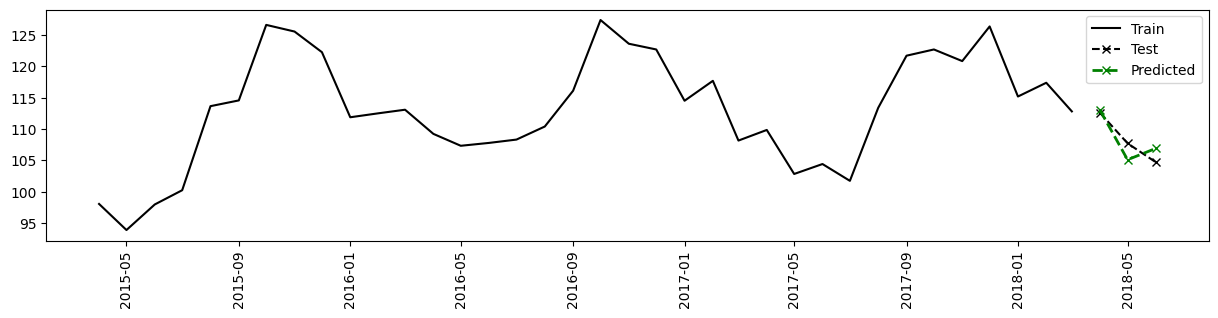

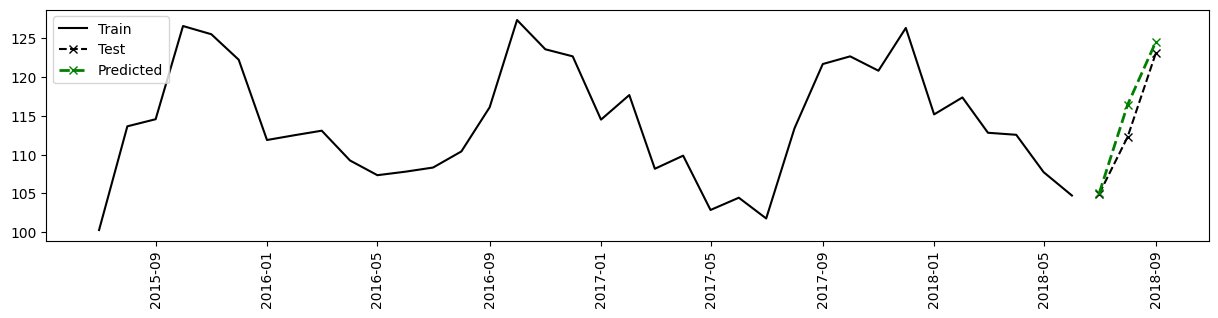

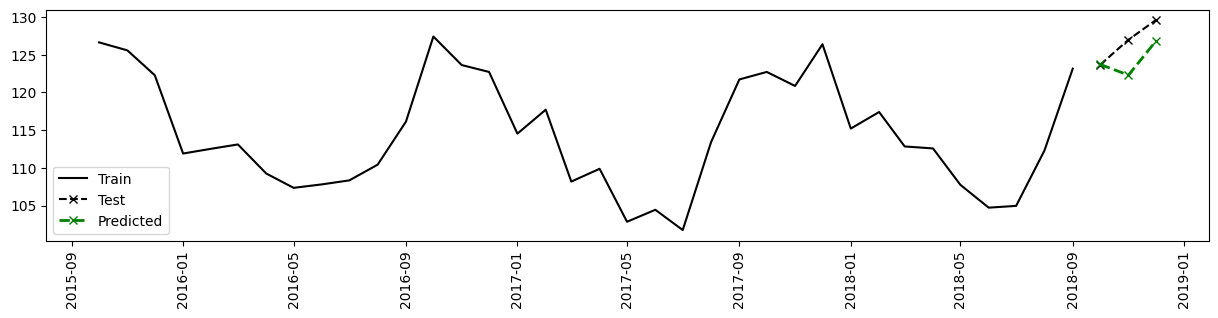

{'MAE': [3.6671199976046136, 9.013888843062604, 3.18447748327903], 'MAPE': [3.376550310329689, 8.015084193064268, 2.4908439415958754], 'RMSE': [4.658723433172603, 11.115347344508107, 3.9437867765103616]}


In [169]:
metrics = {'MAE':[],'MAPE':[],'RMSE':[]}

for train_index, test_index in tscv.split(df):

    #print('Treino:',train_index,'\nTeste:',test_index)

    train = df.iloc[train_index]
    test = df.iloc[test_index]

    model.fit(train)

    y_pred = model.predict(len(test))

    mae, mape, rmse = calculate_metrics(y_pred, y_true=df.loc[df.index.isin(y_pred.index)])

    metrics['MAE'].append(mae)
    metrics['MAPE'].append(mape)
    metrics['RMSE'].append(rmse)


    fig, ax = plt.subplots(figsize=(15,3))
    # Gráficos
    ax.plot(train, label='Train',color='black')
    ax.plot(test, color='black', linestyle='--',marker='x', label='Test')
    ax.plot(y_pred, color='green', linestyle='--',marker='x', label='Predicted', linewidth=2)
    
    ax.tick_params(axis='x', rotation=90)
    ax.legend()
    plt.show()

print(metrics)

## Regressão

## Redes Neurais